In [1]:
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [6]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 1, 50, 124
	n_timesteps, n_features, n_outputs = trainX.shape[1],  trainX.shape[2], trainy.shape[1]
	model = Sequential()
	#model.add(Dense(20, activation='relu', input_shape=(n_features,)))
	#model.add(Dense(60, activation='relu'))
	#model.add(Dropout(0.2))
	#model.add(Dense(120, activation='relu'))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	#model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	#model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	#model.add(MaxPooling1D(pool_size=2))
	#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	#model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.summary()

	# fit network
	history = model.fit(trainX, trainy, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=verbose)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return model, accuracy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [3]:
#load data
# one hot encode y
data = pd.read_pickle("./data.pkl")
targetnames = data['target'].values
data['target'] = pd.factorize(data['target'])[0]
y = data['target']
y = to_categorical(y)

X = data.loc[:, data.columns != 'target'].values
X.sort(axis=1) #sort the data of every row (important)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape, y.shape)
print(X)

(1910000, 100, 1) (1910000, 11)
[[[1.70287493e-02]
  [4.06867124e-02]
  [6.07363168e-02]
  ...
  [9.58386438e-01]
  [9.60112083e-01]
  [9.86645895e-01]]

 [[5.94997972e-04]
  [1.47681028e-02]
  [1.87744241e-02]
  ...
  [9.94020369e-01]
  [9.94628474e-01]
  [9.96114943e-01]]

 [[6.63804511e-03]
  [2.26063351e-02]
  [3.42923514e-02]
  ...
  [9.90724696e-01]
  [9.97355667e-01]
  [9.98880074e-01]]

 ...

 [[4.90665432e-02]
  [6.06402087e-02]
  [6.79898412e-02]
  ...
  [9.65300441e-01]
  [9.96265777e-01]
  [9.98885945e-01]]

 [[9.77180366e-03]
  [2.65676268e-02]
  [2.88494607e-02]
  ...
  [9.73748483e-01]
  [9.91016948e-01]
  [9.96793121e-01]]

 [[1.28879993e-02]
  [2.80048963e-02]
  [4.16890764e-02]
  ...
  [9.59032697e-01]
  [9.71717985e-01]
  [9.97109695e-01]]]


In [4]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 98, 16)            64        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 79,675
Trainable params: 79,675
Non-trainable params: 0
__________________________________________________

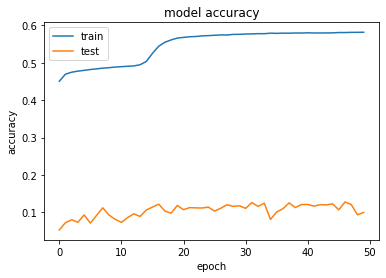

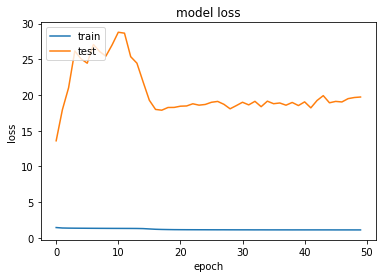

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 98, 16)            64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1111      
Total params: 79,675
Trainable params: 79,675
Non-trainable params: 0
__________________________________________________

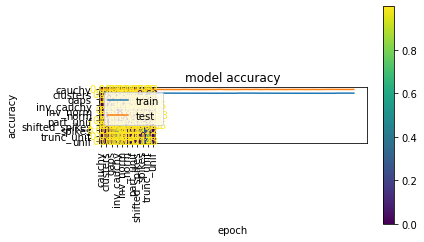

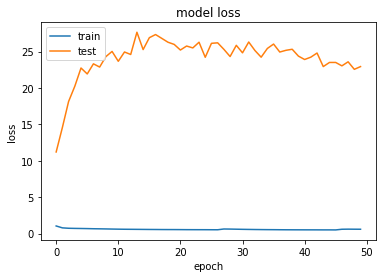

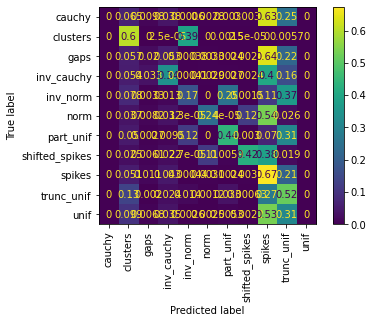

In [7]:
#CV
from sklearn.model_selection import StratifiedKFold

scores = []
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, data['target']):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index,:], y[test_index,:]
    model, score = evaluate_model(X_train, y_train, X_test, y_test)
    scores.append(score)
    
    model1 = newmodel(model)
    plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames))) 

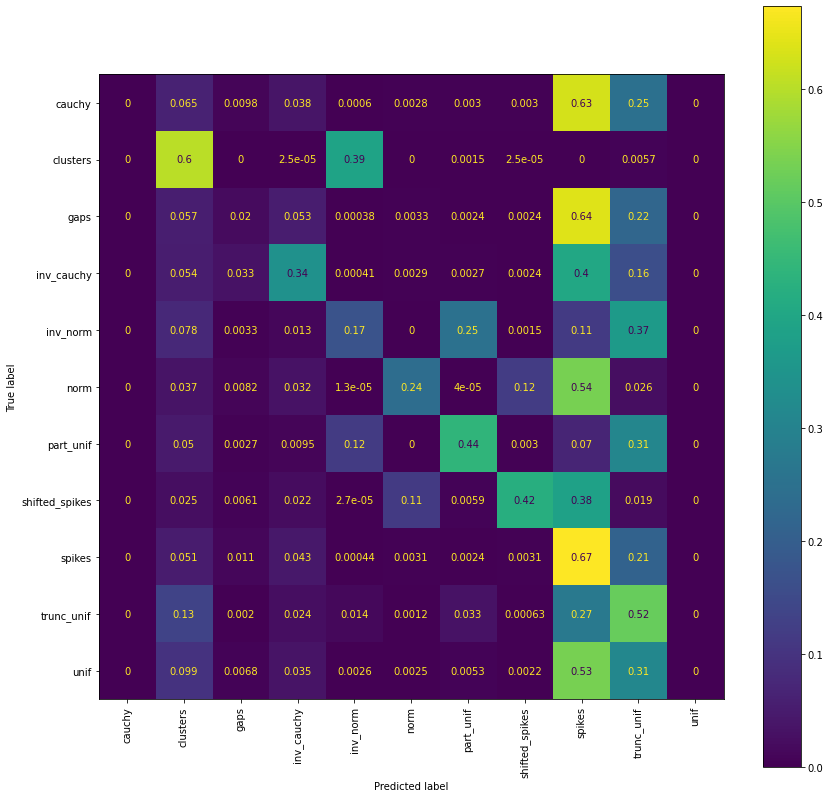

In [10]:
model1 = newmodel(model)
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames)), ax=ax) 
plt.show()

In [20]:
np.argmax(y_test, axis=1)

(955000, 11)

In [ ]:

y_pred = model.predict(X_test)
y_pred.shape

In [21]:
y_test.shape

(955000, 11)